<a href="https://colab.research.google.com/github/AstxMargaryan/ML/blob/main/generative_classifiers_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Generative classifiers

Your task is to implement the following three generative classifiers (Naive Bayes, LDA and QDA). A custom implementation of f1 score must be used for scoring (calculated using tp, tn, fp, fn).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [ ]:
class NaiveBayes:
    def __init__(self, distr='Gaussian'):
        self.distr = distr

    def get_stats(self, X, Y):
      classes = np.unique(Y)
      class_prob = Y.value_counts(normalize=True).to_dict()

      means = {}
      variances = {}

      for c in classes:
          X_c = X[Y == c]
          means[c] = X_c.mean(axis=0).values
          variances[c] = X_c.var(axis=0).values + 1e-6

      return means, variances, class_prob


    def pdf(self, x, mean, variance):
        coef = 1 / np.sqrt(2 * np.pi * variance)
        exponent = -((x - mean) ** 2) / (2 * variance)
        prob = coef * np.exp(exponent)
        return prob

    def fit(self, X_train, y_train):
      self.classes = np.unique(y_train)
      self.means, self.variances, self.class_prob = self.get_stats(X_train, y_train)


    def predict_proba(self, X_test):
        X = X_test.values
        probs = np.zeros((X_test.shape[0], len(self.classes)))

        for idx, c in enumerate(self.classes):
            mean = self.means[c]
            var = self.variances[c]

            likelihood = np.prod(self.pdf(X, mean, var), axis=1)
            probs[:, idx] = likelihood * self.class_prob[c]

        probs = probs / probs.sum(axis=1, keepdims=True)
        return probs

    def predict(self, X_test):
        probs = self.predict_proba(X_test)
        idx_max = np.argmax(probs, axis=1)
        return np.array([self.classes[i] for i in idx_max])

    def score(self, X_test, y_test):
      y_pred = self.predict(X_test)
      y_true = np.array(y_test)

      classes = np.unique(np.concatenate([y_true, y_pred]))
      f1_scores = []

      for c in classes:
        TP, FP, TN, FN = 0, 0, 0, 0

        for i in range(len(y_pred)):
          if y_true[i] == c and y_pred[i] == c:
            TP += 1
          elif y_true[i] != c and y_pred[i] == c:
            FP += 1
          elif y_true[i] != c and y_pred[i] != c:
            TN += 1
          elif y_true[i] == c and y_pred[i] != c:
            FN += 1

        Precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
        Recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0

        F1 = (2 * Precision * Recall) / (Precision + Recall) if (Precision + Recall) != 0 else 0.0
        f1_scores.append(F1)

      return float(np.mean(f1_scores))



In [ ]:
NaiveBayes


__main__.NaiveBayes

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)


X_train = pd.DataFrame(X_train, columns=iris.feature_names)
X_test  = pd.DataFrame(X_test,  columns=iris.feature_names)
y_train = pd.Series(y_train)
y_test  = pd.Series(y_test)

In [ ]:
nb = NaiveBayes()


In [ ]:
nb


In [ ]:
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
proba  = nb.predict_proba(X_test)

print("First 10 predictions:", y_pred[:10])
print("First row proba:", proba[0])

f1 = nb.score(X_test, y_test)
print("my F1 score::", f1)


First 10 predictions: [0 0 0 0 0 0 0 1 0 0]
First row proba: [0.60394079 0.39605921]
my F1 score:: 0.6897959183673468


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

sk_nb = GaussianNB()
sk_nb.fit(X_train, y_train)

sk_nb_pred = sk_nb.predict(X_test)
sk_nb_proba = sk_nb.predict_proba(X_test)

print("F1 sklearn Naive Bayes:", f1_score(y_test, sk_nb_pred, average="macro"))


F1 sklearn Naive Bayes: 0.702202961357891


In [ ]:
class LinearDA:
    def __init__(self):
        pass

    def get_stats(self, X_train, y_train):
      classes = pd.unique(y_train)
      class_prob = y_train.value_counts(normalize=True).to_dict()

      means = {c: X_train[y_train == c].mean(axis=0).values for c in classes}

      n_samples = X_train.shape[0]
      pooled_cov = np.zeros((X_train.shape[1], X_train.shape[1]))

      for c in classes:
          X_c = X_train[y_train == c].values
          n_c = X_c.shape[0]
          cov_c = np.cov(X_c, rowvar=False, bias=False)
          pooled_cov += (n_c - 1) * cov_c

      pooled_cov /= (n_samples - len(classes))

      return means, pooled_cov, class_prob



    def ldf(self, x, mean, class_proba):
      term1 = x.T @ self.inv_cov @ mean
      term2 = -0.5 * (mean.T @ self.inv_cov @ mean)
      term3 = np.log(class_proba + 1e-12)
      return term1 + term2 + term3


    def fit(self, X_train, y_train):
      self.classes = pd.unique(y_train)
      self.means, self.shared_cov, self.class_prob = self.get_stats(X_train, y_train)
      eps = 1e-8
      self.inv_cov = np.linalg.inv(self.shared_cov + eps * np.eye(self.shared_cov.shape[0]))

    def predict_proba(self, X_test):
      proba = []

      for _, row in X_test.iterrows():
          x = row.values
          scores = []

          for c in self.classes:
              mean = self.means[c]
              prior = self.class_prob[c]
              score = self.ldf(x, mean, prior)
              scores.append(score)

          scores = np.array(scores)
          exp_scores = np.exp(scores - scores.max())
          probs = exp_scores / exp_scores.sum()

          proba.append(probs)

      return np.array(proba)


    def predict(self, X_test, eps=0):
      probs = self.predict_proba(X_test)
      idx = np.argmax(probs, axis=1)
      return np.array([self.classes[i] for i in idx])



    def score(self, X_test, y_test):
      y_pred = self.predict(X_test)
      y_true = np.array(y_test)

      classes = np.unique(np.concatenate([y_true, y_pred]))
      f1_scores = []

      for c in classes:
        TP, FP, TN, FN = 0, 0, 0, 0

        for i in range(len(y_pred)):
          if y_true[i] == c and y_pred[i] == c:
            TP += 1
          elif y_true[i] != c and y_pred[i] == c:
            FP += 1
          elif y_true[i] != c and y_pred[i] != c:
            TN += 1
          elif y_true[i] == c and y_pred[i] != c:
            FN += 1

        Precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
        Recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0

        F1 = (2 * Precision * Recall) / (Precision + Recall) if (Precision + Recall) != 0 else 0.0
        f1_scores.append(F1)

      return float(np.mean(f1_scores))



In [ ]:
lda = LinearDA()
lda.fit(X_train, y_train)


In [ ]:
y_pred = lda.predict(X_test)
proba = lda.predict_proba(X_test)
print("First 10 predictions:", y_pred[:10])
print("Probabilities of first sample:", proba[0])
f1 = lda.score(X_test, y_test)
print("my F1 score::", f1)


First 10 predictions: [0 0 0 0 0 0 0 0 0 0]
Probabilities of first sample: [0.61170474 0.38829526]
my F1 score:: 0.6913675742574257


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sk = LinearDiscriminantAnalysis()
sk.fit(X_train, y_train)
sk_pred = sk.predict(X_test)
sk_proba = sk.predict_proba(X_test)
print("F1 sk:", f1_score(y_test, sk_pred, average="macro"))

F1 sk: 0.6913675742574257


In [ ]:
class QuadraticDA:
    def __init__(self):
        pass

    def get_stats(self, X_train, y_train):
        classes = pd.unique(y_train)
        class_prob = y_train.value_counts(normalize=True).to_dict()

        means = {}
        covs = {}

        for c in classes:
            X_c = X_train[y_train == c].values
            means[c] = X_c.mean(axis=0)
            covs[c] = np.cov(X_c, rowvar=False, bias=False)

        return means, covs, class_prob

    def qdf(self, x, mean, inv_cov, log_det_cov, class_proba):
        term1 = -0.5 * log_det_cov
        term2 = -0.5 * ((x - mean).T @ inv_cov @ (x - mean))
        term3 = np.log(class_proba + 1e-12)
        return term1 + term2 + term3

    def fit(self, X_train, y_train):
        self.classes = pd.unique(y_train)
        self.means, self.covs, self.class_prob = self.get_stats(X_train, y_train)

        self.inv_covs = {}
        self.log_det_covs = {}

        eps = 1e-8
        n_features = X_train.shape[1]

        for c in self.classes:
            cov = self.covs[c] + eps * np.eye(n_features)

            self.inv_covs[c] = np.linalg.inv(cov)

            sign, logdet = np.linalg.slogdet(cov)
            self.log_det_covs[c] = logdet

    def predict_proba(self, X_test):
        proba = []

        for _, row in X_test.iterrows():
            x = row.values
            scores = []

            for c in self.classes:
                mean = self.means[c]
                inv_cov = self.inv_covs[c]
                log_det = self.log_det_covs[c]
                prior = self.class_prob[c]

                score = self.qdf(x, mean, inv_cov, log_det, prior)
                scores.append(score)

            scores = np.array(scores)
            exp_scores = np.exp(scores - scores.max())
            probs = exp_scores / exp_scores.sum()

            proba.append(probs)

        return np.array(proba)

    def predict(self, X_test):
        probs = self.predict_proba(X_test)
        idx = np.argmax(probs, axis=1)
        return np.array([self.classes[i] for i in idx])

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_true = np.array(y_test)

        classes = np.unique(np.concatenate([y_true, y_pred]))
        f1_scores = []

        for c in classes:
            TP, FP, TN, FN = 0, 0, 0, 0

            for i in range(len(y_pred)):
                if y_true[i] == c and y_pred[i] == c:
                    TP += 1
                elif y_true[i] != c and y_pred[i] == c:
                    FP += 1
                elif y_true[i] != c and y_pred[i] != c:
                    TN += 1
                elif y_true[i] == c and y_pred[i] != c:
                    FN += 1

            Precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
            Recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0

            F1 = (2 * Precision * Recall) / (Precision + Recall) if (Precision + Recall) != 0 else 0.0
            f1_scores.append(F1)

        return float(np.mean(f1_scores))


In [ ]:
qda = QuadraticDA()
qda.fit(X_train, y_train)

In [ ]:
y_pred = qda.predict(X_test)
proba = qda.predict_proba(X_test)

print("First 10 predictions:", y_pred[:10])
print("Probabilities of first sample:", proba[0])

f1 = qda.score(X_test, y_test)
print("my F1 score:", f1)


First 10 predictions: [1 0 0 0 0 0 0 0 0 0]
Probabilities of first sample: [0.35381575 0.64618425]
my F1 score: 0.756615990990991


In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

sk_qda = QuadraticDiscriminantAnalysis()
sk_qda.fit(X_train, y_train)

sk_qda_pred = sk_qda.predict(X_test)
sk_qda_proba = sk_qda.predict_proba(X_test)

print("F1 sklearn QDA:", f1_score(y_test, sk_qda_pred, average="macro"))


F1 sklearn QDA: 0.7566159909909911


# 2. Solve classification problem using 'classification.csv' dataset

Visualize the data, do some EDA. The target variable is 'default'. Apply feature selection, feature scaling, cross validation etc. (anything you think is needed). Split the data into train/test, train a classiffication model (whichever model works best, experiment!) and evaluate on the test data. Print the various metrics discussed during the lecture on both sets.

Note: you are permitted to use external libraries for the models themselves, but not for the metrics. You must implement all the metrics yourselves.

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_validate,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv('classification.csv')

In [ ]:
df.head(5)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,college degree,17,12,176,9.3,11.359392,5.008608,1
1,27,no high school,10,6,31,17.3,1.362202,4.000798,0
2,40,no high school,15,14,55,5.5,0.856075,2.168925,0
3,41,no high school,15,14,120,2.9,2.658720,0.821280,0
4,24,high school,2,0,28,17.3,1.787436,3.056564,1


In [ ]:
df.shape

(700, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       700 non-null    int64  
 1   ed        700 non-null    object 
 2   employ    700 non-null    int64  
 3   address   700 non-null    int64  
 4   income    700 non-null    int64  
 5   debtinc   700 non-null    float64
 6   creddebt  700 non-null    float64
 7   othdebt   700 non-null    float64
 8   default   700 non-null    int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 49.3+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,700.0,34.860000,7.997342,20.000000,29.000000,34.000000,40.000000,56.00000
employ,700.0,8.388571,6.658039,0.000000,3.000000,7.000000,12.000000,31.00000
address,700.0,8.278571,6.824877,0.000000,3.000000,7.000000,12.000000,34.00000
income,700.0,45.601429,36.814226,14.000000,24.000000,34.000000,55.000000,446.00000
debtinc,700.0,10.260571,6.827234,0.400000,5.000000,8.600000,14.125000,41.30000
creddebt,700.0,1.553553,2.117197,0.011696,0.369059,0.854869,1.901955,20.56131
othdebt,700.0,3.058209,3.287555,0.045584,1.044178,1.987567,3.923065,27.03360
default,700.0,0.261429,0.439727,0.000000,0.000000,0.000000,1.000000,1.00000


In [ ]:
df.isnull().sum()

,0
age,0
ed,0
employ,0
address,0
income,0
debtinc,0
creddebt,0
othdebt,0
default,0


<Axes: >

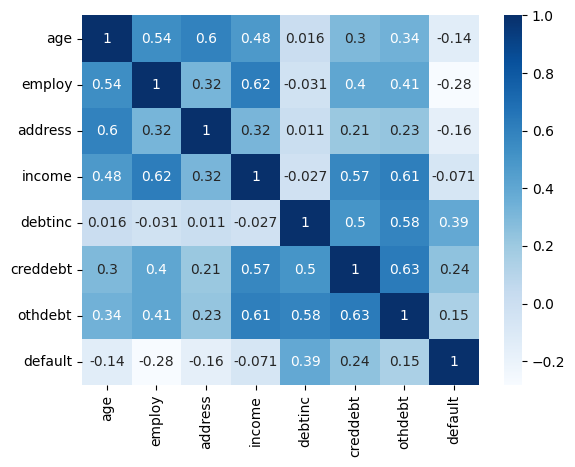

In [ ]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap = "Blues", annot= True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       700 non-null    int64  
 1   ed        700 non-null    object 
 2   employ    700 non-null    int64  
 3   address   700 non-null    int64  
 4   income    700 non-null    int64  
 5   debtinc   700 non-null    float64
 6   creddebt  700 non-null    float64
 7   othdebt   700 non-null    float64
 8   default   700 non-null    int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 49.3+ KB


In [ ]:
df["age"]

,age
0,41
1,27
2,40
3,41
4,24
...,...
695,36
696,29
697,33
698,45


<Axes: xlabel='age', ylabel='Count'>

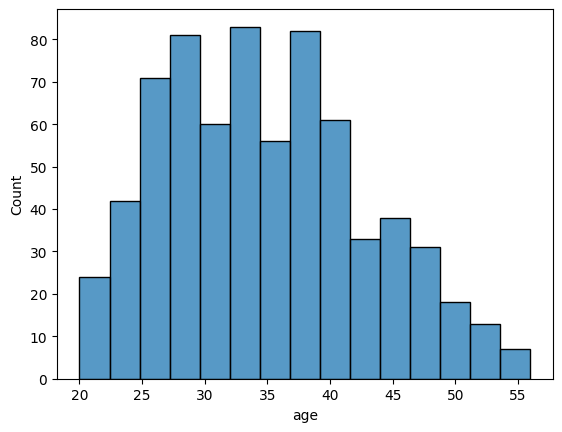

In [ ]:
sns.histplot(df["age"])

In [ ]:
df["ed"]

,ed
0,college degree
1,no high school
2,no high school
3,no high school
4,high school
...,...
695,high school
696,high school
697,no high school
698,no high school


In [ ]:
df["ed"].unique()

array(['college degree', 'no high school', 'high school', 'undergraduate',
       'postgraduate'], dtype=object)

<Axes: xlabel='count', ylabel='ed'>

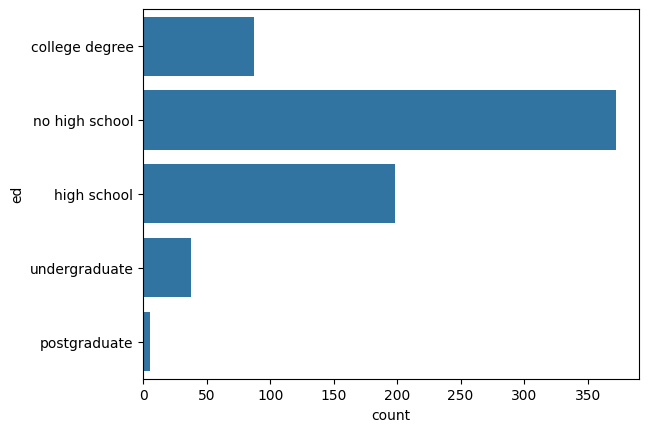

In [ ]:
sns.countplot(df["ed"])

In [ ]:
df["employ"]

,employ
0,17
1,10
2,15
3,15
4,2
...,...
695,6
696,6
697,15
698,19


<Axes: xlabel='employ', ylabel='Count'>

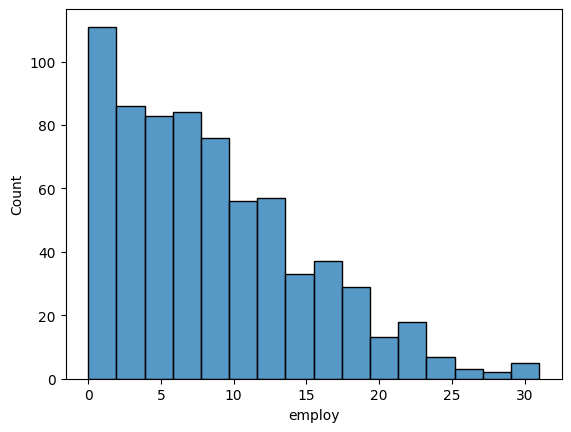

In [ ]:
sns.histplot(df["employ"])

<Axes: ylabel='employ'>

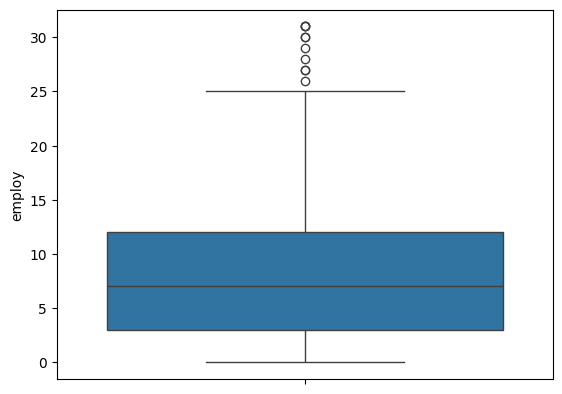

In [ ]:
sns.boxplot(df["employ"])

In [ ]:
df["employ_log"] = np.log1p(df["employ"])

<Axes: xlabel='employ_log', ylabel='Count'>

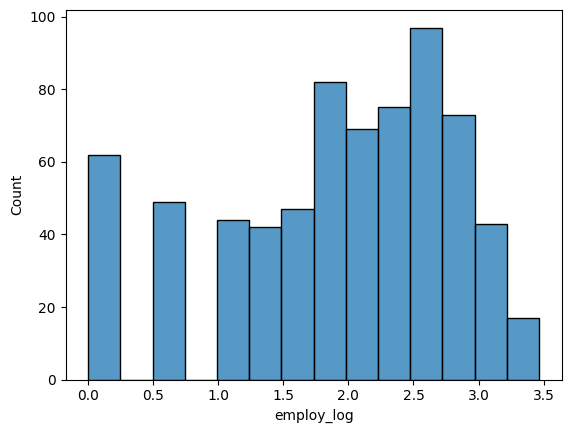

In [ ]:
sns.histplot(df["employ_log"])

<Axes: ylabel='employ_log'>

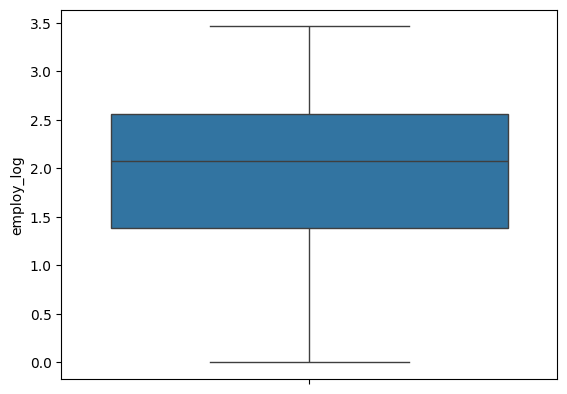

In [ ]:
sns.boxplot(df["employ_log"])

In [ ]:
df.drop("employ", axis = 1, inplace= True)

In [ ]:
df["address"]

,address
0,12
1,6
2,14
3,14
4,0
...,...
695,15
696,4
697,3
698,22


<Axes: xlabel='address', ylabel='Count'>

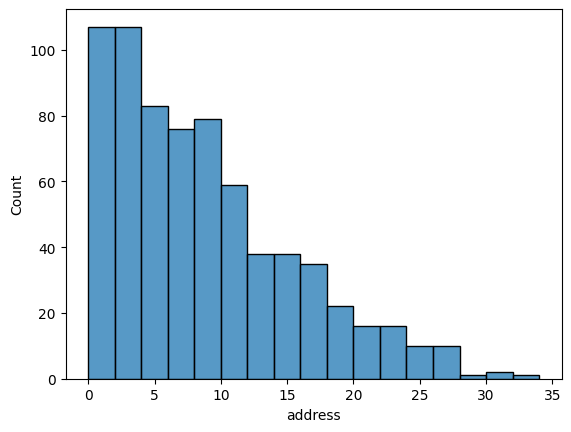

In [ ]:
sns.histplot(df["address"])

<Axes: ylabel='address'>

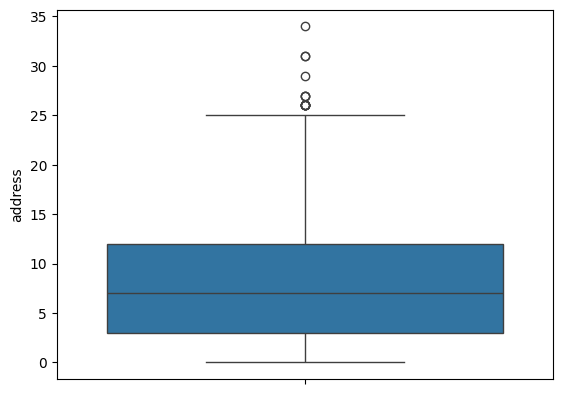

In [ ]:
sns.boxplot(df["address"])

In [ ]:
df["address_log"] = np.log1p(df["address"])

<Axes: xlabel='address_log', ylabel='Count'>

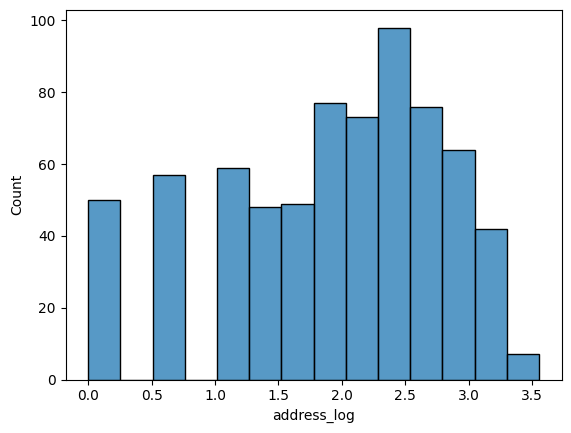

In [ ]:
sns.histplot(df["address_log"])

<Axes: ylabel='address_log'>

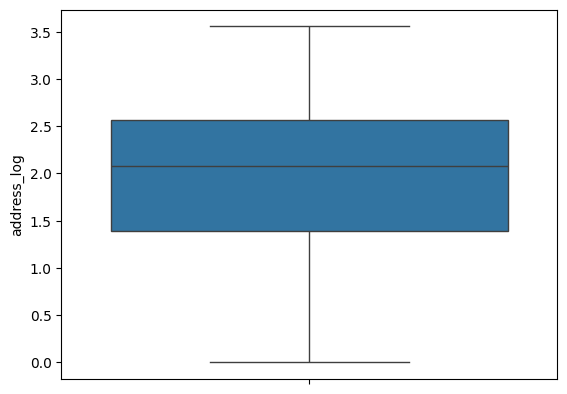

In [ ]:
sns.boxplot(df["address_log"])

In [ ]:
df.drop("address", axis = 1, inplace = True)

In [ ]:
df["income"]

,income
0,176
1,31
2,55
3,120
4,28
...,...
695,27
696,21
697,32
698,77


<Axes: xlabel='income', ylabel='Count'>

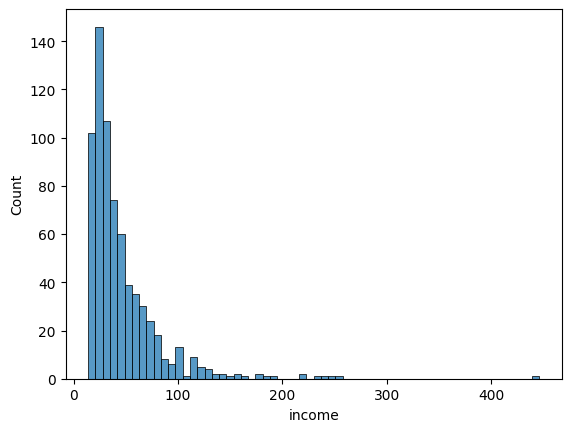

In [ ]:
sns.histplot(df["income"])

<Axes: ylabel='income'>

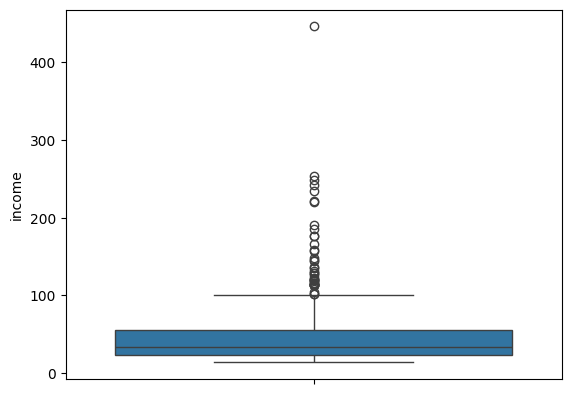

In [ ]:
sns.boxplot(df["income"])

In [ ]:
df["income_log"] = np.log1p(df["income"])

<Axes: xlabel='income_log', ylabel='Count'>

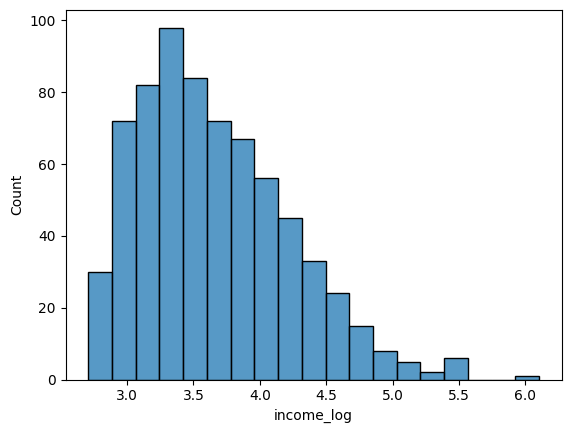

In [ ]:
sns.histplot(df["income_log"])

<Axes: ylabel='income_log'>

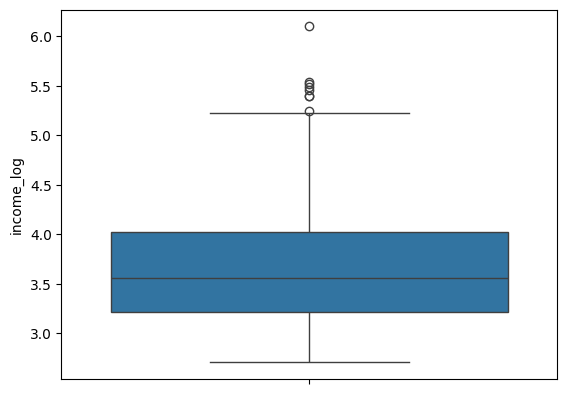

In [ ]:
sns.boxplot(df["income_log"])

In [ ]:
def IQR(dataframe, column_name):
  Q1 = dataframe[column_name].quantile(0.25)
  Q3 = dataframe[column_name].quantile(0.75)

  iqr = Q3 - Q1

  lower_bound = Q1 - 1.5 * iqr
  upper_bound = Q3 + 1.5 * iqr

  dataframe = dataframe[(dataframe[column_name] >= lower_bound) & (dataframe[column_name] <= upper_bound)]

  return dataframe


In [ ]:
df = IQR(df, "income_log")

<Axes: xlabel='income_log', ylabel='Count'>

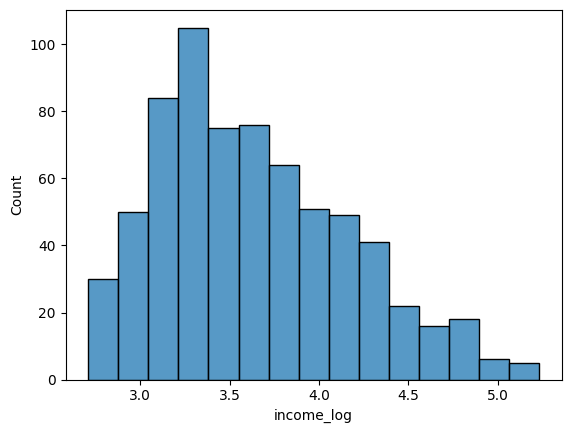

In [ ]:
sns.histplot(df["income_log"])

<Axes: ylabel='income_log'>

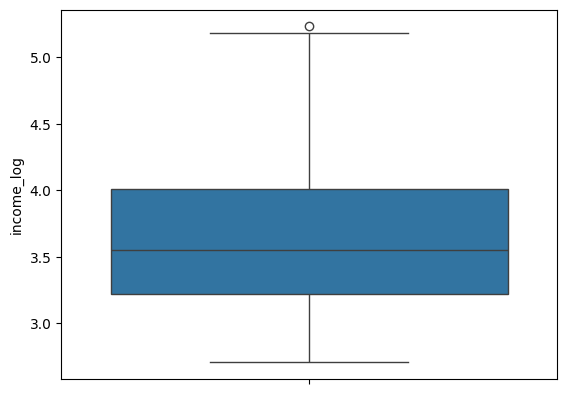

In [ ]:
sns.boxplot(df["income_log"])

In [ ]:
df.drop("income", axis=1, inplace = True)

In [ ]:
df["debtinc"]

,debtinc
0,9.3
1,17.3
2,5.5
3,2.9
4,17.3
...,...
695,4.6
696,11.5
697,7.6
698,8.4


<Axes: xlabel='debtinc', ylabel='Count'>

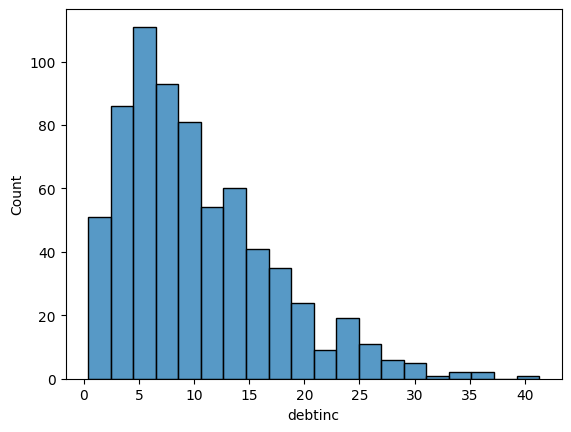

In [ ]:
sns.histplot(df["debtinc"])

<Axes: ylabel='debtinc'>

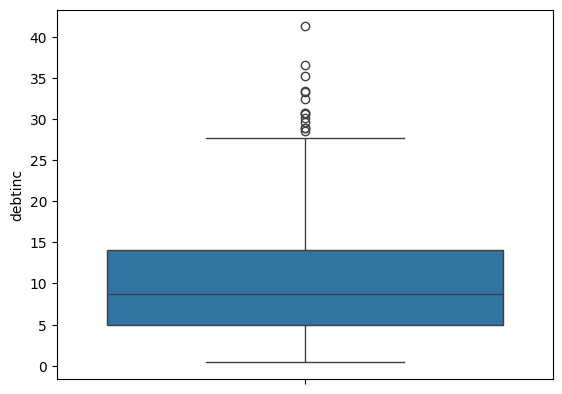

In [ ]:
sns.boxplot(df["debtinc"])

In [ ]:
df = IQR(df, "debtinc")

<Axes: ylabel='debtinc'>

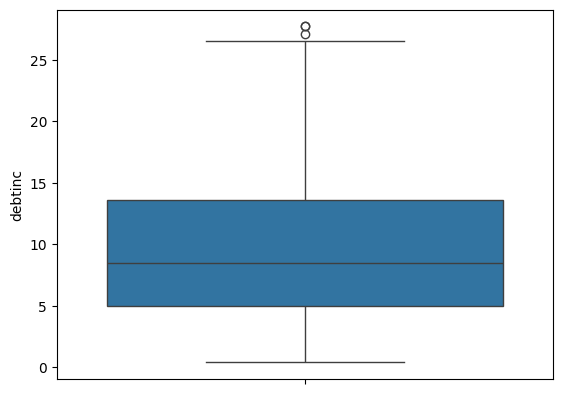

In [ ]:
sns.boxplot(df["debtinc"])

<Axes: xlabel='debtinc', ylabel='Count'>

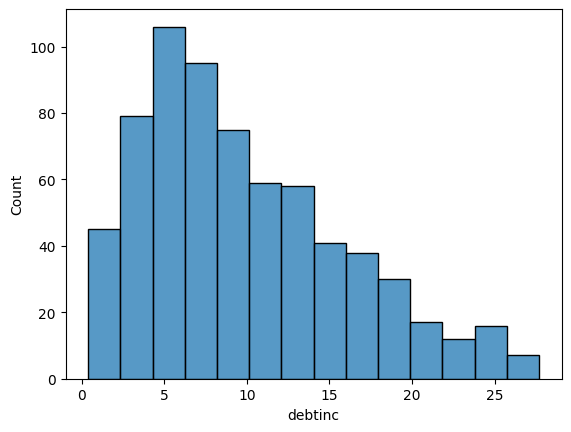

In [ ]:
sns.histplot(df["debtinc"])

In [ ]:
df["creddebt"]

,creddebt
0,11.359392
1,1.362202
2,0.856075
3,2.658720
4,1.787436
...,...
695,0.262062
696,0.369495
697,0.491264
698,2.302608


<Axes: xlabel='creddebt', ylabel='Count'>

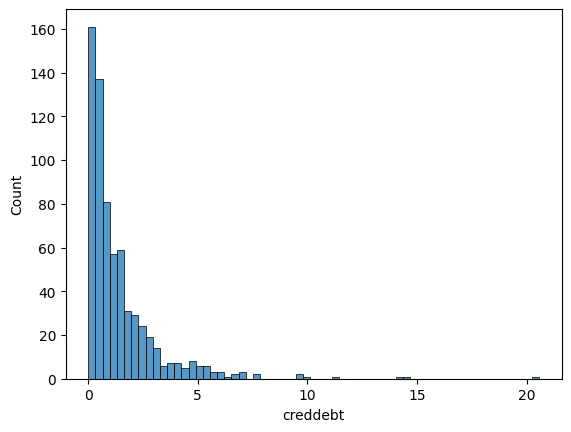

In [ ]:
sns.histplot(df["creddebt"])

<Axes: ylabel='creddebt'>

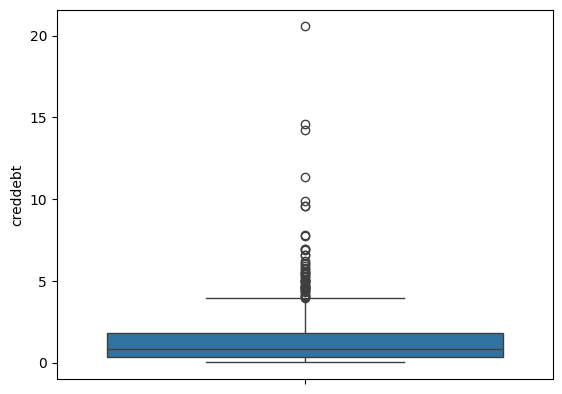

In [ ]:
sns.boxplot(df["creddebt"])

In [ ]:
df["creddebt_log"] = np.log1p(df["creddebt"])

<Axes: xlabel='creddebt_log', ylabel='Count'>

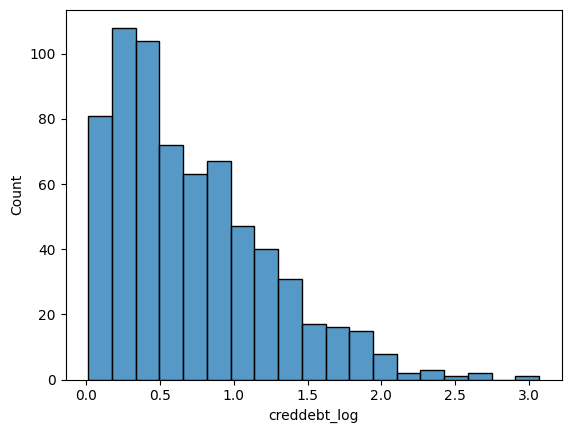

In [ ]:
sns.histplot(df["creddebt_log"])

<Axes: ylabel='creddebt_log'>

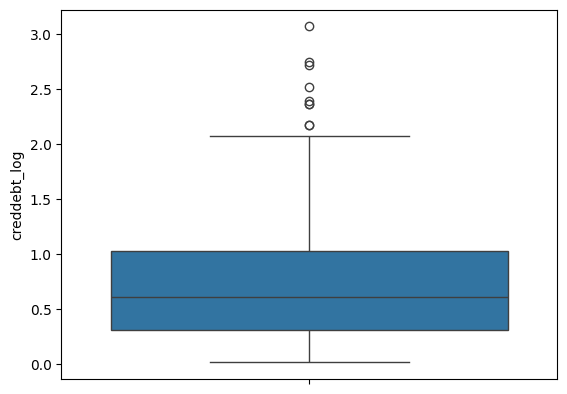

In [ ]:
sns.boxplot(df["creddebt_log"])

In [ ]:
df = IQR(df, 'creddebt_log')

<Axes: ylabel='creddebt_log'>

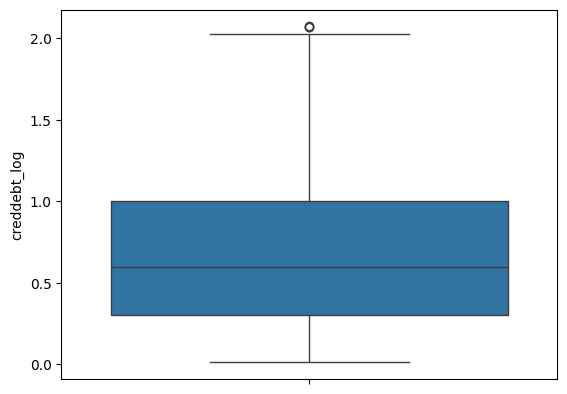

In [ ]:
sns.boxplot(df["creddebt_log"])

<Axes: xlabel='creddebt_log', ylabel='Count'>

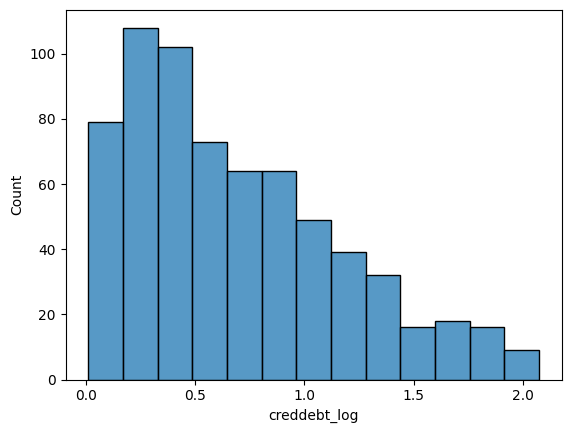

In [ ]:
sns.histplot(df["creddebt_log"])

In [ ]:
df.drop('creddebt', axis = 1, inplace = True)

In [ ]:
df["othdebt"]

,othdebt
1,4.000798
2,2.168925
3,0.821280
4,3.056564
5,2.157300
...,...
695,0.979938
696,2.045505
697,1.940736
698,4.165392


<Axes: xlabel='othdebt', ylabel='Count'>

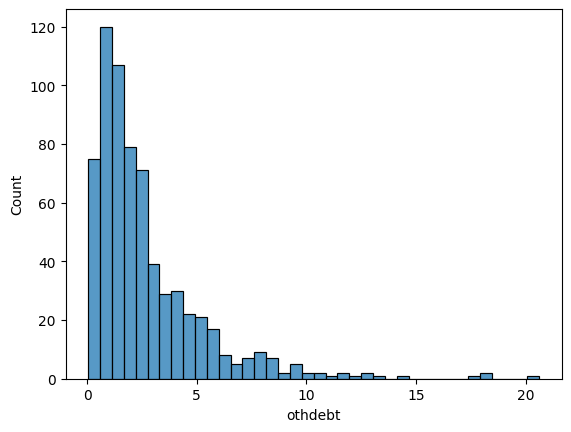

In [ ]:
sns.histplot(df["othdebt"])

<Axes: ylabel='othdebt'>

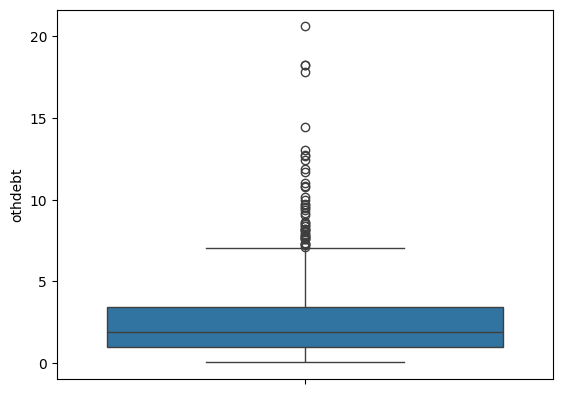

In [ ]:
sns.boxplot(df["othdebt"])

In [ ]:
df["othdebt_log"] = np.log1p(df["othdebt"])

<Axes: xlabel='othdebt_log', ylabel='Count'>

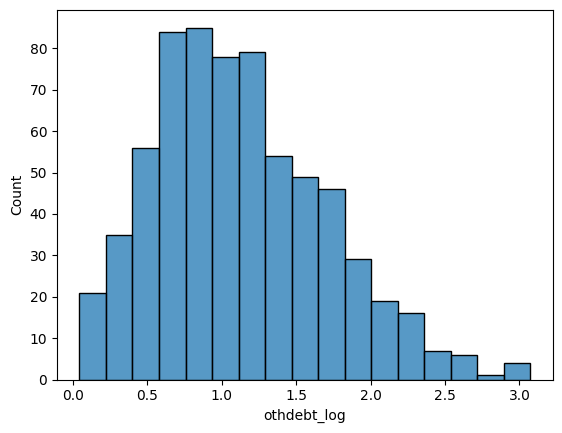

In [ ]:
sns.histplot(df["othdebt_log"])

<Axes: ylabel='othdebt_log'>

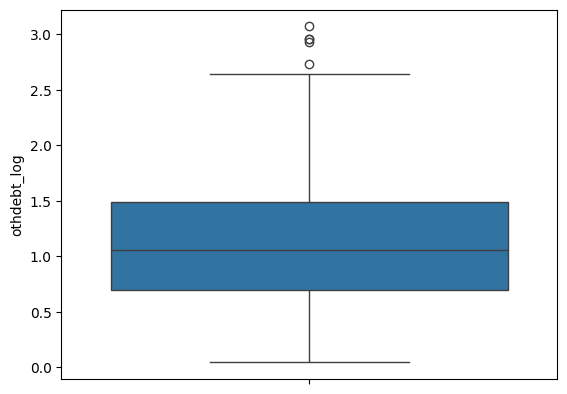

In [ ]:
sns.boxplot(df["othdebt_log"])

In [ ]:
df = IQR(df, "othdebt_log")

<Axes: xlabel='othdebt_log', ylabel='Count'>

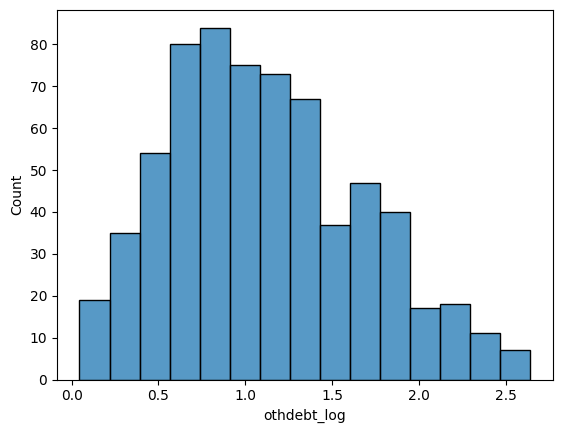

In [ ]:
sns.histplot(df["othdebt_log"])

<Axes: ylabel='othdebt_log'>

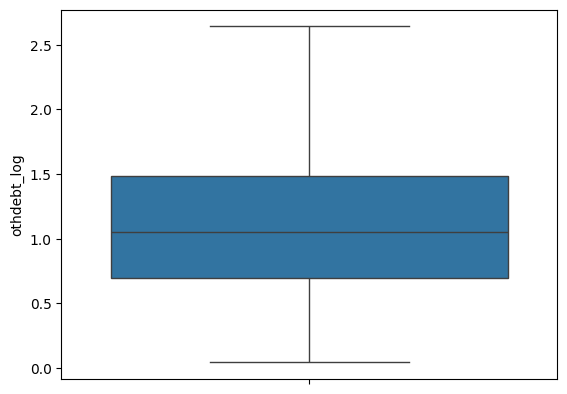

In [ ]:
sns.boxplot(df["othdebt_log"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 664 entries, 1 to 699
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           664 non-null    int64  
 1   ed            664 non-null    object 
 2   debtinc       664 non-null    float64
 3   othdebt       664 non-null    float64
 4   default       664 non-null    int64  
 5   employ_log    664 non-null    float64
 6   address_log   664 non-null    float64
 7   income_log    664 non-null    float64
 8   creddebt_log  664 non-null    float64
 9   othdebt_log   664 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 57.1+ KB


In [ ]:
df.drop('othdebt', axis = 1, inplace = True)

<Axes: >

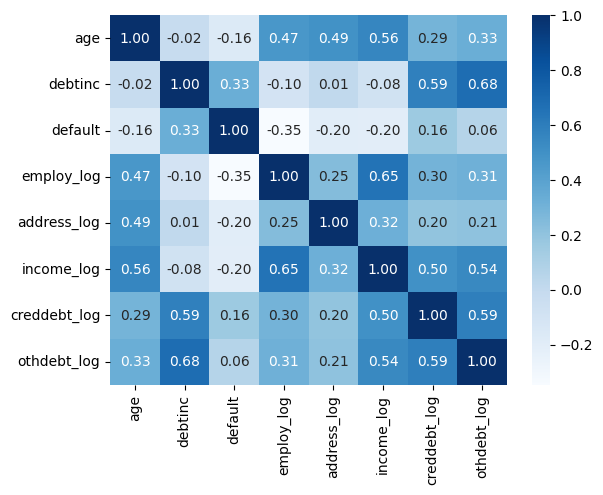

In [ ]:
corr1 = df.corr(numeric_only = True)
sns.heatmap(corr1, cmap = 'Blues', fmt = '.2f', annot = True)

<Axes: xlabel='default', ylabel='Count'>

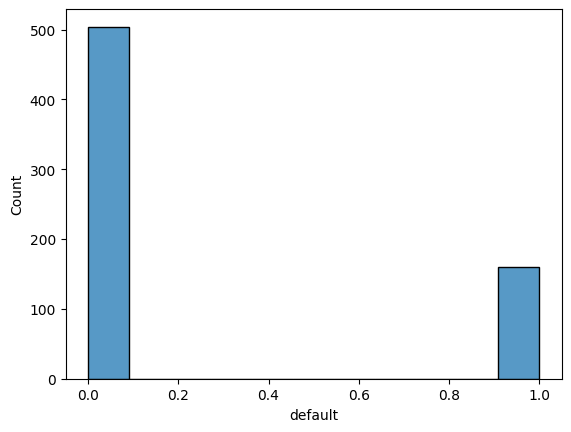

In [ ]:
sns.histplot(df["default"])

In [ ]:
df['default'].value_counts(normalize = True)

,proportion
default,
0,0.759036
1,0.240964


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 664 entries, 1 to 699
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           664 non-null    int64  
 1   ed            664 non-null    object 
 2   debtinc       664 non-null    float64
 3   default       664 non-null    int64  
 4   employ_log    664 non-null    float64
 5   address_log   664 non-null    float64
 6   income_log    664 non-null    float64
 7   creddebt_log  664 non-null    float64
 8   othdebt_log   664 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.9+ KB


In [ ]:
df["ed"].unique()

array(['no high school', 'high school', 'college degree', 'undergraduate',
       'postgraduate'], dtype=object)

In [ ]:
ed_mapping = {
    'no high school': 0,
    'high school': 1,
    'college degree': 2,
    'undergraduate': 3,
    'postgraduate': 4}

df['ed'] = df['ed'].map(ed_mapping)

In [ ]:
df['ed'].unique()

array([0, 1, 2, 3, 4])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 664 entries, 1 to 699
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           664 non-null    int64  
 1   ed            664 non-null    int64  
 2   debtinc       664 non-null    float64
 3   default       664 non-null    int64  
 4   employ_log    664 non-null    float64
 5   address_log   664 non-null    float64
 6   income_log    664 non-null    float64
 7   creddebt_log  664 non-null    float64
 8   othdebt_log   664 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 51.9 KB


In [ ]:
X = df.drop('default', axis = 1)


In [ ]:
X

,age,ed,debtinc,employ_log,address_log,income_log,creddebt_log,othdebt_log
1,27,0,17.3,2.397895,1.945910,3.465736,0.859594,1.609597
2,40,0,5.5,2.772589,2.708050,4.025352,0.618464,1.153392
3,41,0,2.9,2.772589,2.708050,4.795791,1.297113,0.599540
4,24,1,17.3,1.098612,0.000000,3.367296,1.025122,1.400336
5,41,1,10.2,1.791759,1.791759,3.258097,0.331244,1.149717
...,...,...,...,...,...,...,...,...
695,36,1,4.6,1.945910,2.772589,3.332205,0.232747,0.683066
696,29,1,11.5,1.945910,1.609438,3.091042,0.314442,1.113667
697,33,0,7.6,2.772589,1.386294,3.496508,0.399624,1.078660
698,45,0,8.4,2.995732,3.135494,4.356709,1.194712,1.641981


In [ ]:
Y = df["default"]

In [ ]:
Y

,default
1,0
2,0
3,0
4,1
5,0
...,...
695,1
696,0
697,0
698,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=90, max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=150, random_state=90),
    "XGBoost": XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss', random_state=90),
    "LightGBM": LGBMClassifier(is_unbalance=True, n_estimators=150, random_state=90)
}

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)

In [ ]:
scoring = {
    'F1': make_scorer(f1_score),
    'ROC-AUC': 'roc_auc'
}

In [ ]:
results = []

for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring = scoring)
    results.append({
        'Model': name,
        'Mean F1': scores['test_F1'].mean(),
        'Std F1': scores['test_F1'].std(),
        'Mean ROC-AUC': scores['test_ROC-AUC'].mean(),
        'Std ROC-AUC': scores['test_ROC-AUC'].std()
    })

cv_results = pd.DataFrame(results)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:33:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:33:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:33:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:33:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:33:41] WARNING: /w

[LightGBM] [Info] Number of positive: 96, number of negative: 328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 424, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226415 -> initscore=-1.228665
[LightGBM] [Info] Start training from score -1.228665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
cv_results

,Model,Mean F1,Std F1,Mean ROC-AUC,Std ROC-AUC
0,Logistic Regression,0.542887,0.047369,0.805329,0.066931
1,Random Forest,0.348469,0.022349,0.785032,0.041751
2,XGBoost,0.366044,0.047382,0.747971,0.050068
3,LightGBM,0.402126,0.085786,0.746323,0.060170


In [ ]:
log_reg = LogisticRegression(random_state = 90)

In [ ]:
param_dist = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300, 500, 800],
    'class_weight': ['balanced', None]
}

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)

In [ ]:
random_search = RandomizedSearchCV(
    log_reg,
    param_distributions=param_dist,
    n_iter=30,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=90,
    verbose=2
)

In [ ]:
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=90, shuffle=True),
                   estimator=LogisticRegression(random_state=90), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'class_weight': ['balanced', None],
                                        'max_iter': [100, 200, 300, 500, 800],
                                        'penalty': ['l2', 'l1'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=90, scoring='roc_auc', verbose=2)

In [ ]:
print("Best hyperparameters found:", random_search.best_params_)

Best hyperparameters found: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'class_weight': 'balanced', 'C': np.float64(0.08858667904100823)}


In [ ]:
lg = random_search.best_estimator_

In [ ]:
y_predict = lg.predict(X_test_scaled)

In [ ]:
def score(y_test, y_predict):

        TP,FP,TN,FN = 0,0,0,0
        y_test = y_test.reset_index(drop = True)

        for i in range(len(y_predict)):
            if y_test[i]==y_predict[i]==1:
                TP += 1
            elif y_predict[i]==1 and y_test[i]!=y_predict[i]:
                FP += 1
            elif y_test[i]==y_predict[i]==0:
                TN += 1
            elif y_predict[i]==0 and y_test[i]!=y_predict[i]:
                FN += 1

        Precision = TP / (TP + FP)
        Recall = TP / (TP + FN)
        Accuracy = (TP + TN) / (TP + TN + FP + FN)

        F1 = (2 * Precision * Recall) / (Precision + Recall) if (Precision + Recall) != 0 else 0

        return Accuracy, Precision, Recall, F1


In [ ]:
Accuracy, Precision, Recall, F1 = score(y_test, y_predict)

In [ ]:
roc_auc_score_lg = roc_auc_score(y_test, lg.predict_proba(X_test_scaled)[:, 1])

In [ ]:
print(f'LogisticRegression metrics: accuracy = {Accuracy*100:.2f}%, precision = {Precision:.2f}, recall = {Recall:.2f}, F1 = {F1:.2f}, roc_auc_score = {roc_auc_score_lg:.2f}')

LogisticRegression metrics: accuracy = 78.20%, precision = 0.60, recall = 0.82, F1 = 0.69, roc_auc_score = 0.87


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test_scaled)[:,1])

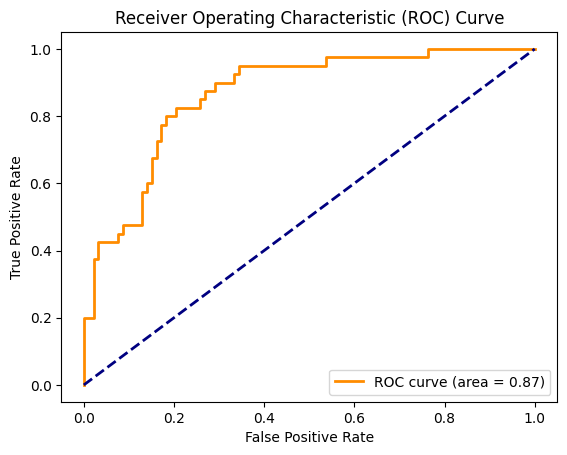

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score_lg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(conf_matrix)

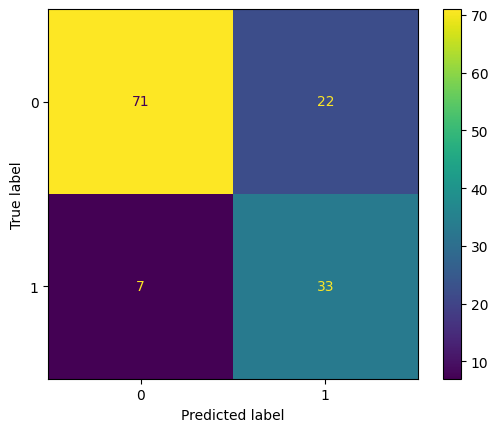

In [ ]:
disp.plot()

In [ ]:
rf = RandomForestClassifier(random_state = 80)

In [ ]:
param_dist_rf = {
    'n_estimators': np.arange(50, 800, 50),
    'max_depth': [None, 10, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 5, 10, 20, 23],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]  }

In [ ]:
skf1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=40,
    cv=skf1,
    scoring='f1',
    n_jobs=-1,
    random_state=80,
    verbose=2
)

In [ ]:
random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=80), n_iter=40,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20, 23],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750])},
                   random_state=80, scoring='f1', verbose=2)

In [ ]:
print("Best hyperparameters found:", random_search_rf.best_params_)

Best hyperparameters found: {'n_estimators': np.int64(150), 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 50, 'class_weight': 'balanced', 'bootstrap': True}


In [ ]:
rf1 = random_search_rf.best_estimator_
y_predict_rf = rf1.predict(X_test)

In [ ]:
Accuracy, Precision, Recall, F1 = score(y_test, y_predict_rf)

In [ ]:
roc_auc_score_rf = roc_auc_score(y_test, rf1.predict_proba(X_test)[:, 1])

In [ ]:
print(f'RandomForest metrics: accuracy = {Accuracy*100:.2f}%, precision = {Precision:.2f}, recall = {Recall:.2f}, F1 = {F1:.2f}, roc_auc_score = {roc_auc_score_rf:.2f}')

RandomForest metrics: accuracy = 77.44%, precision = 0.60, recall = 0.72, F1 = 0.66, roc_auc_score = 0.84


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, rf1.predict_proba(X_test)[:,1])

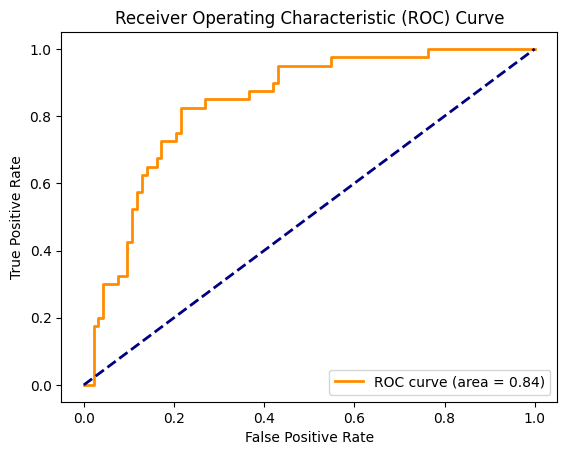

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predict_rf)
disp = ConfusionMatrixDisplay(conf_matrix)

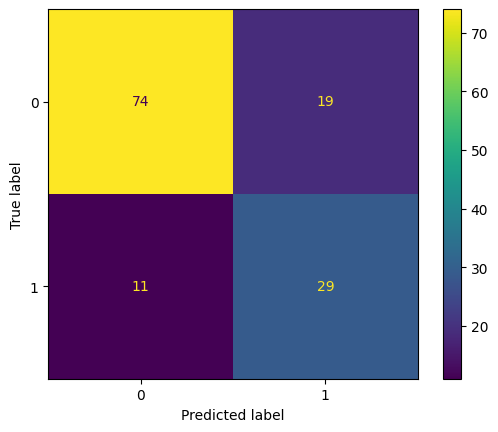

In [ ]:
disp.plot()